In [5]:
%matplotlib inline
import os
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV


from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [6]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [5]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle',
 'unique_mol2vec_embedding.pickle',
 '__pycache__']

In [32]:
class RunCCA:
    def __init__(self, view1, view2,dims=2):
        self.v1 = view1
        self.v2 = view2
        self.dims = dims
    
    def train_cca(self):
        # step 0: init the model
        linear_cca = CCA(latent_dims=self.dims,scale=False)
        
        # step 1: train (fit and transform)
        train_z1, train_z2 = linear_cca.fit_transform([self.v1, self.v2])
        
        #step 3: extract correlation between the dims of the 2 views
        train_corr = linear_cca.score([self.v1, self.v2])
        
        # bundle them in dfs
        
        # 1 latent_spaces
        train_latent_spaces = pd.DataFrame(list(zip(train_z1,train_z2)),\
                      columns=['train_z1','train_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        train_cor_df = pd.DataFrame(list(zip(dims,train_corr)),\
                      columns=['latent_dim','cor'])
        
        return linear_cca, train_latent_spaces, train_cor_df
        
    def test_cca(self, model):
            
            
        # transform the test dataset
        test_z1, test_z2 = model.transform([self.v1,self.v2])
        test_corr = model.score([self.v1, self.v2])
            
        # bundle them in dfs
        
        # 1 latent_spaces
        test_latent_spaces = pd.DataFrame(list(zip(test_z1,test_z2)),\
                      columns=['test_z1','test_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        test_cor_df = pd.DataFrame(list(zip(dims,test_corr)),\
                          columns=['latent_dim','cor'])
        
        return test_latent_spaces, test_cor_df
         

### Train A CCA model with MS2DeepScore embeddings

#### 1. Unfiltered Embeddings

In [33]:
# load df with all info
path = './df_classes_all_embeddings.pickle'
df_all = Files(path).load_pickle()#[:10000] #just a subset for scripting
df_all.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,CCMSLIB00000001547,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901464462280273, 37.367000579833984, ...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,CCMSLIB00000001548,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.6031694412231445, 12.245128631591797, ...","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000001549,"[-6.807433213493404, 2.8870356459664226, -4.28...","[28.570608139038086, 7.199506759643555, 10.875...","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
3,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000071752,"[-3.703751099226352, -2.2908253516762493, 6.72...","[17.48873519897461, 0.0, 29.71199607849121, 0....","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
4,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,CCMSLIB00000001550,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309712409973145, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives


In [34]:
# #drop inchikeys appering once, to make it possible to stratify based on inchikey
#df_all = df_all.groupby('inchi_key').filter(lambda x : len(x)>5)
df_all.shape

(302514, 8)

In [35]:
#split the dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['inchi_key'])

v1_train, v1_test = [x for x in train_df['ms2ds']], [x for x in test_df['ms2ds']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [36]:
# train the model
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.806200
1,2,0.347727
2,3,0.336020
3,4,0.280584
4,5,0.202966


In [11]:
# test the model
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.805268
1,2,0.350770
2,3,0.332670
3,4,0.294328
4,5,0.197938


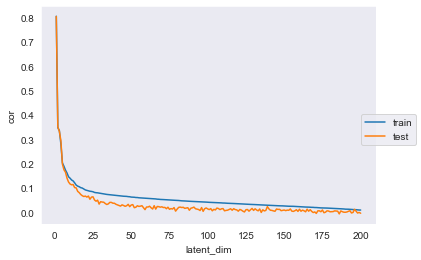

In [92]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()

#### 2. filtered Embeddings

In [37]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_uniq = Files(path).load_pickle()#[:10000] #just a subset for scripting
df_uniq.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,...",Macrolactams
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -...",Peptidomimetics
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522...",Carboxylic acids and derivatives


In [38]:
#split the dataset
train_df, test_df = \
train_test_split(df_uniq, test_size=0.2, \
                 random_state=42)

v1_train, v1_test = [x for x in train_df['ms2ds']], [x for x in test_df['ms2ds']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [10]:
# # normalising slightly improves spec2vec but slightly decreases ms2ds
# v1_train, v1_test = normalize(v1_train), normalize(v1_test)
# v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [39]:
# train the model
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.899808
1,2,0.844028
2,3,0.806704
3,4,0.797919
4,5,0.753063


In [40]:
# test the model
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.889260
1,2,0.826607
2,3,0.769665
3,4,0.785805
4,5,0.740144


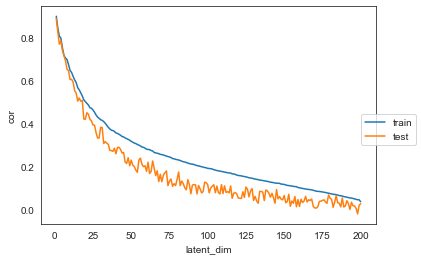

In [42]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()

The validation function used here was downloaded from [CCA_zoo](https://cca-zoo.readthedocs.io/en/latest/auto_examples/plot_validation.html#sphx-glr-auto-examples-plot-validation-py) documentation; same function can also be found in [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) documentation

In [23]:
from cca_zoo.model_selection import permutation_test_score
from plot_validation import plot_learning_curve
from sklearn.model_selection import KFold, ShuffleSplit


In [15]:
v1_train = np.array(v1_train)
v2_train = np.array(v2_train)

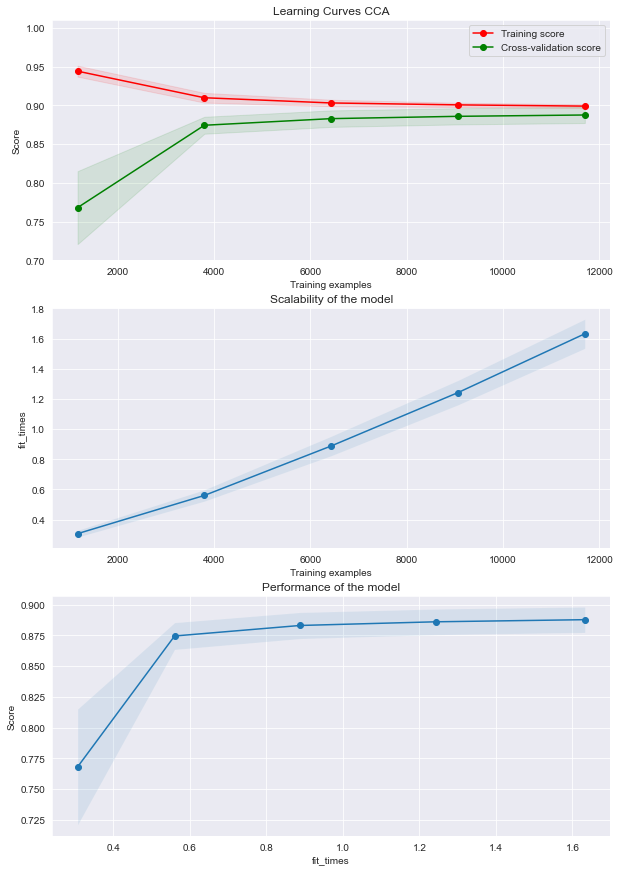

In [16]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves CCA"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
model = CCA()
plot_learning_curve(model, title, \
                    (v1_train, v2_train), axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()



### Train A CCA model with Spec2vec embeddings

#### 1. Unfiltered spec2vec Embeddings

In [43]:
#split the dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['inchikey14'])

v1_train, v1_test = [x for x in train_df['spec2vec']], [x for x in test_df['spec2vec']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [44]:
# normalising slightly improves spec2vec but slightly decreases ms2ds
v1_train, v1_test = normalize(v1_train), normalize(v1_test)
v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [45]:
# train the model with spec2vec unfiltered embeddings
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.778072
1,2,0.638414
2,3,0.603951
3,4,0.561841
4,5,0.502176


In [46]:
# test the model (unfiltered spec2vec)
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.776700
1,2,0.636609
2,3,0.599964
3,4,0.559839
4,5,0.495697


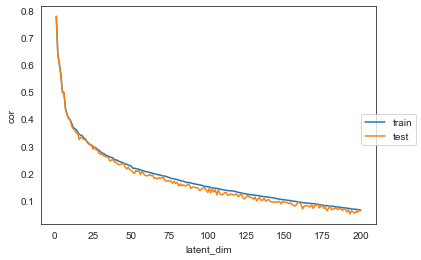

In [47]:
# plot train correlation vs test correlation (unfiltered spec2vec)
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()

#### 2. Filtered Spec2vec Embeddings

In [48]:
#split the dataset (filtered spec2vec)
train_df, test_df = \
train_test_split(df_uniq, test_size=0.2, \
                 random_state=42)

v1_train, v1_test = [x for x in train_df['spec2vec']], [x for x in test_df['spec2vec']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [49]:
# normalizing slightly improves spec2vec
v1_train, v1_test = normalize(v1_train), normalize(v1_test)
v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [50]:
# train the model with spec2vec filtered embeddings
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.801794
1,2,0.741277
2,3,0.722125
3,4,0.686932
4,5,0.648152


In [51]:
# test the model (filtered spec2vec)
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.791494
1,2,0.713723
2,3,0.685799
3,4,0.641021
4,5,0.624926


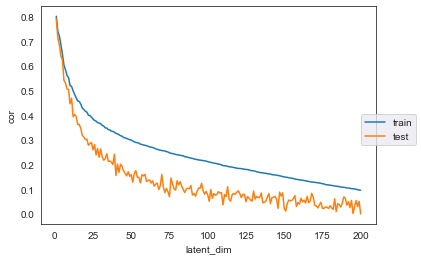

In [52]:
# plot train correlation vs test correlation (unfiltered spec2vec)
fig, ax = plt.subplots()
sns.set_style('dark')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()

In [21]:
v1_train = np.array(v1_train)
v2_train = np.array(v2_train)

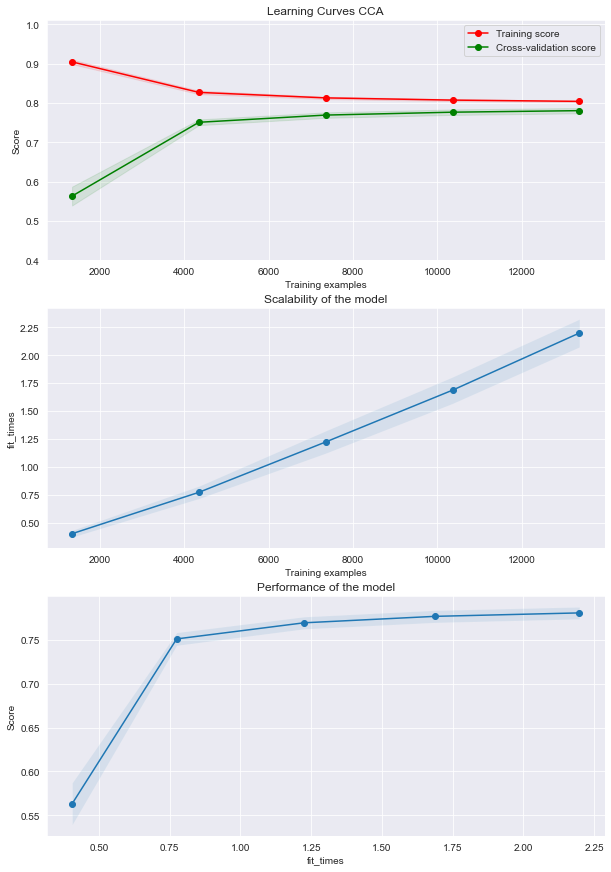

In [35]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves CCA"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
model = CCA()
plot_learning_curve(model, title, \
                    (v1_train, v2_train), axes=axes, ylim=(0.4, 1.01), cv=cv, n_jobs=4)
plt.show()

In [53]:
from ms2deepscore import data_generator

ImportError: cannot import name 'data_generator' from 'ms2deepscore' (C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\ms2deepscore\__init__.py)